# Mask R-CNN - Inspect Tom and Jerry Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [ ]:
!pip install tensorflow==1.5.0
!pip install 'keras==2.1.6' --force-reinstall
!pip3 install scipy==1.1.0 --user

In [ ]:
!pip freeze

In [ ]:
cd /content/drive/My\ Drive//Mask_RCNN-2.1

/content/drive/My Drive/Mask_RCNN-2.1


In [ ]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont


# Root directory of the project
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
if ROOT_DIR.endswith("samples/characters"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
import config
from visualize import display_images
import model as modellib
from model import log

from samples.characters import TomJerry

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to TomJerry trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
CHARACTER_WEIGHTS_PATH = "/content/drive/My Drive/Mask_RCNN-2.1/logs/characters20200417T2109/mask_rcnn_characters_0015.h5"  # TODO: update this path

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

/content/drive/My Drive/Mask_RCNN-2.1


Using TensorFlow backend.


## Configurations

In [ ]:
config = TomJerry.CharacterConfig()
CHARACTER_DIR = os.path.join(ROOT_DIR, 'json_data')

In [ ]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           characters
NUM_CLASSES                    3
POOL_SIZE                      7
POST_NMS_ROIS_INF

## Notebook Preferences

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Data

In [ ]:

# Load validation dataset
dataset = TomJerry.CharacterDataset()
dataset.load_characters(CHARACTER_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

['via_export_json (1) (2).json']
['Episode 1 (copy)', 'episode_2', 'Frame_89.jpg', 'Frame_221.jpg', 'Frame_354.jpg']
via_export_json (1) (2).json
Episode 1 (copy)
Images: 50
Classes: ['BG', 'tom', 'jerry']


## Load Model

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [ ]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = '/content/drive/My Drive/Mask_RCNN-2.1/logs/characters20200421T1905/mask_rcnn_characters_0049.h5'

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/My Drive/Mask_RCNN-2.1/logs/characters20200421T1905/mask_rcnn_characters_0049.h5


In [ ]:
len(os.listdir('/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/jerry_black'))

127

In [ ]:
# font = ImageFont.load_default()

# draw = ImageDraw.Draw(pil_img)
# draw.text(( 20, 32), "text_string", (255,0,0), font=font)

## Run Detection

In [ ]:
import cv2
global tom_count
global jerry_count 
tom_count = 0
jerry_count = 0

In [ ]:
# Function to load all images and detect tom/jerry get the mask resize it and then finally save the images to generate data for emotion prediction model
def detect_crop_save(root_folder_path):

  '''
  Function to load all images and detect tom/jerry get the mask resize it and 
  then finally save the images to generate data for emotion prediction model
  '''
  for frame_folder in os.listdir(root_folder_path):
    print('\n')
    print(f'Extracting images from folder: {frame_folder} \n')
    frame_folder_path = os.path.join(root_folder_path, frame_folder)
    image_count = 0
    total_image_count = len(os.listdir(frame_folder_path))
    for image in os.listdir(frame_folder_path):
      image_count += 1
      print(f'Processing {image_count}/{total_image_count} image!')
      image_path = os.path.join(frame_folder_path, image)

      image = cv2.imread(image_path)
      image = np.array(image)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image.astype(np.float32)
      
      image7, window, scale, padding = utils.resize_image(
            image,
            min_dim=config.IMAGE_MIN_DIM,
            max_dim=config.IMAGE_MAX_DIM,
            padding=config.IMAGE_PADDING)
      # Detect objects
      # print(image3.shape)
      image7 = np.array(image7)
      r = model.detect([image7])[0]


      dictionary = get_class_id_score_dict(r['class_ids'], r['scores'])
      print(f'Image Path: {image_path}')
      print(r['class_ids'])
      print(dictionary)

      get_all_bbox_and_save(r['rois'], r['masks'], dictionary, r['class_ids'], image7)
      # get_all_masks_and_save(r['masks'], dictionary, r['class_ids'], image7)

In [ ]:
detect_crop_save('/content/drive/My Drive/Mask_RCNN-2.1/test')



Extracting images from folder: 1 

Processing 1/2 image!
Image Path: /content/drive/My Drive/Mask_RCNN-2.1/test/1/Frame_89.jpg
[1 2]
{1: [0.9994236], 2: [0.97696245]}
Tom cropped face saved! at 4.png
Jerry cropped face saved! at 5.png


Processing 2/2 image!
Image Path: /content/drive/My Drive/Mask_RCNN-2.1/test/1/Frame_2.jpg
[2]
{2: [0.9985]}
Jerry cropped face saved! at 6.png




In [ ]:
# function to check for image aspect ratio
from PIL import Image

def make_square(im, min_size=256, fill_color=(0, 0, 0, 255)):
    '''
    function to check for image aspect ratio
    Input - im: Image in PIL Image format.
    '''
    x, y = im.size
    min_size = max(x, y)
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

## Testing Cells!

In [ ]:
# Testing Cell
import cv2
image_path = '/content/drive/My Drive/Mask_RCNN-2.1/datasets/characters/train/TomandJerryTales-TheItch(2007)/Frame_89.jpg'

image = cv2.imread(image_path)
image = np.array(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image6, window, scale, padding = utils.resize_image(
      image,
      min_dim=config.IMAGE_MIN_DIM,
      max_dim=config.IMAGE_MAX_DIM,
      padding=config.IMAGE_PADDING)
# Detect objects
# print(image3.shape)
image6 = np.array(image6)
r = model.detect([image6], verbose=1)[0]


dictionary = get_class_id_score_dict(r['class_ids'], r['scores'])
print(r['class_ids'])
print(dictionary)
get_all_bbox_and_save(r['rois'], r['masks'], dictionary, r['class_ids'], image6)
# get_all_masks_and_save(r['masks'], dictionary, r['class_ids'], image6)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  142.10000
image_metas              shape: (1, 11)               min:    0.00000  max: 1024.00000
[1 2]
{1: [0.9994236], 2: [0.97696245]}
Tom cropped face saved! at 3.png
Jerry cropped face saved! at 4.png




In [ ]:
r['rois']


array([[300, 545, 545, 858]], dtype=int32)

In [ ]:
[y1, x1, y2, x2] = r['rois'][2]


In [ ]:
crop_img = image6[y1:y2, x1:x2]
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)

In [ ]:
cv2.imwrite('/content/drive/My Drive/Mask_RCNN-2.1/test1.png' , crop_img)

True

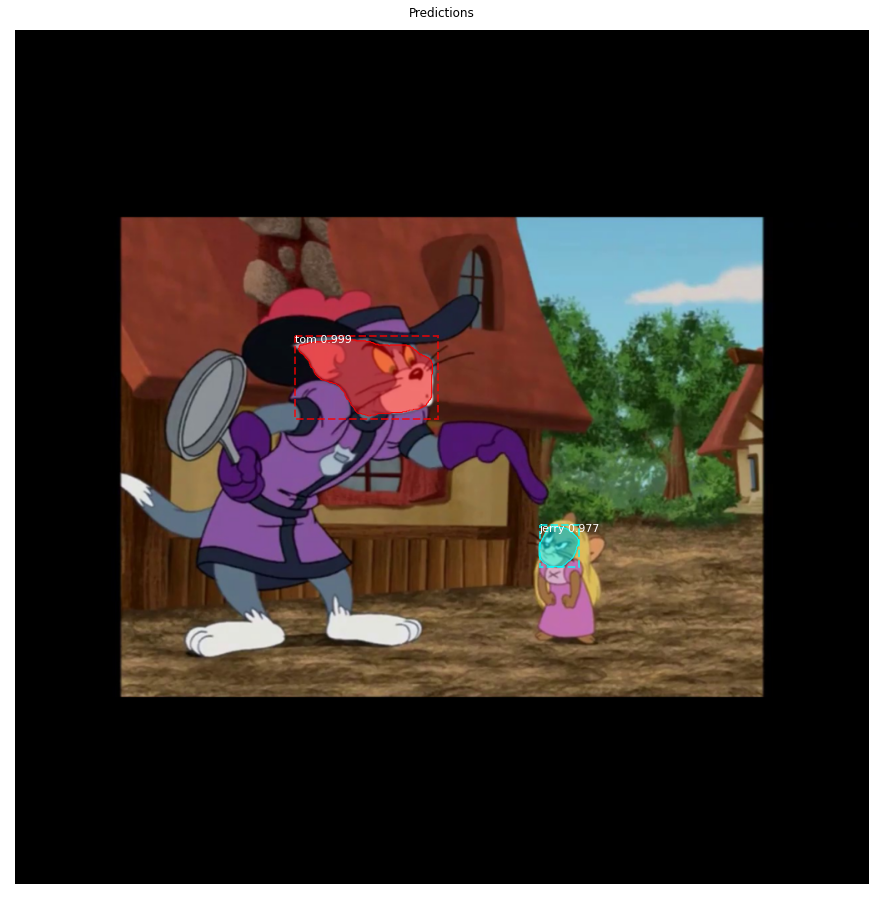

In [ ]:
ax = get_ax(1)
visualize.display_instances(image6, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'tom', 'jerry'], r['scores'], ax=ax,
                            title="Predictions")

In [ ]:
global tom_count
global jerry_count
tom_count = 0
jerry_count = 0

for image_id in range(5):
  # image_id = random.choice(dataset.image_ids)
  image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
      
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                        dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]

  dictionary = get_class_id_score_dict(r['class_ids'], r['scores'])
  print(dictionary)
  get_all_masks_and_save(r['masks'], dictionary)

# Important Cells!

In [ ]:
# Function that returns a dictionary of class_ids as indexes and list of scores for the corresponding class_ids as values
def get_class_id_score_dict(class_ids, scores):

  '''Function that returns a dictionary of class_ids as indexes and list of 
     scores for the corresponding class_ids as values'''

  id_score_tuple_list = []
  for id, score in zip(class_ids, scores):
    id_score_tuple_list.append((id, score))
  
  from collections import defaultdict
  d1=defaultdict(list)
  for k,v in id_score_tuple_list:
    d1[k].append(v)
  d1 = dict(d1)
  return d1

In [ ]:
dictionary = get_class_id_score_dict(r['class_ids'], r['scores'])
print(dictionary)

{1: [0.99886596], 2: [0.9950309]}


In [ ]:
# Classifer Function that returns the mask array of specificly Tom else Jerry else Unknown
def get_specific_mask(masks, dictionary):

  '''
  Classifer Function that returns the mask array of specificly Tom else Jerry 
  else Unknown.

  Input: 
  masks - Array of all masks returned by detect function in model.py
  dictionary - dict of class_ids and their respective scores

  Returns: 
  Returns Array of either tom's mask if found else jerry's mask and if neither 
  of the above two is passed then returns unknown.
  '''
  if 1 in dictionary:
    # Found Tom Mask in the image
    # Get the max score index if more than 1 toms are detected
    tom_max_score_index = np.array(dictionary[1]).argmax()
    if 2 in dictionary:
      final_tom_index = len(dictionary[2]) + tom_max_score_index
    else:
      final_tom_index = tom_max_score_index     
    # Generate mask for Tom
    tom_mask =  masks[:,:,final_tom_index]
    return tom_mask

  elif 2 in dictionary:
    # Found Jerry Mask in the image
    # Get the max score index if more than 1 Jerrys are detected
    jerry_max_score_index = np.array(dictionary[2]).argmax()
    final_jerry_index = jerry_max_score_index
    # Generate mask for Jerry
    jerry_mask =  masks[:,:,final_jerry_index]
    return jerry_mask

  else:
    pass

# specific_mask = get_specific_mask(r['masks'], dictionary)

In [ ]:
def get_all_bbox_and_save(bbox, masks,  dictionary, class_ids_arr, image):

  '''
  Function that does everything.
  Input: bbox = r['rois'], bbox coordinates,
         masks = r['masks'] masks array,
         dictionary = dict containing info of class with their scores,
         class_ids_arr = [1 2],
         image = Original Image (1024*1024)

   Returns: Saves the Tom/Jerry cropped-resized (264*264) mask in their 
            respected Folders.   
  '''

  path_to_save_tom_face = '/content/drive/My Drive/Mask_RCNN-2.1/e-i-2/tom/'
  path_to_save_jerry_face = '/content/drive/My Drive/Mask_RCNN-2.1/e-i-2/jerry/'

  path_to_save_tom_face_black = '/content/drive/My Drive/Mask_RCNN-2.1/e-i-2/tom_black/'
  path_to_save_jerry_face_black = '/content/drive/My Drive/Mask_RCNN-2.1/e-i-2/jerry_black/'

  global tom_count
  global jerry_count

  class_ids_array = class_ids_arr

  if 1 in dictionary:
    tom_count += 1
    final_tom_index, = np.where(class_ids_array == 1)
    final_tom_index2 = final_tom_index[0]
    tom_mask =  masks[:,:,final_tom_index2]
    big_frame_tom_mask = get_mask(tom_mask, image)

    # [y1, x1, y2, x2] = bbox[0]
    [y1, x1, y2, x2] = bbox[final_tom_index2]

    crop_img = image[y1:y2, x1:x2]

    pil_crop_image = Image.fromarray(crop_img)
    new_image = make_square(pil_crop_image)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    crop_image_black = big_frame_tom_mask[y1:y2, x1:x2]

    pil_crop_image_black = Image.fromarray(crop_image_black)
    new_image = make_square(pil_crop_image_black)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_image_black = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    cv2.imwrite(path_to_save_tom_face +  str(tom_count) + '.png', crop_img)
    cv2.imwrite(path_to_save_tom_face_black +  str(tom_count) + '.png', crop_image_black)
    print(f'Tom cropped face saved! at {tom_count}.png')

  if 2 in dictionary:
    jerry_count += 1
    final_jerry_index, = np.where(class_ids_array == 2)
    final_jerry_index2 = final_jerry_index[0]
    jerry_mask =  masks[:,:,final_jerry_index2]
    big_frame_jerry_mask = get_mask(jerry_mask, image)

    # [y1, x1, y2, x2] = bbox[0]
    [y1, x1, y2, x2] = bbox[final_jerry_index2]

    crop_img = image[y1:y2, x1:x2]

    pil_crop_image = Image.fromarray(crop_img)
    new_image = make_square(pil_crop_image)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    crop_image_black = big_frame_jerry_mask[y1:y2, x1:x2]

    pil_crop_image_black = Image.fromarray(crop_image_black)
    new_image = make_square(pil_crop_image_black)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_image_black = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    cv2.imwrite(path_to_save_jerry_face +  str(jerry_count) + '.png', crop_img)
    cv2.imwrite(path_to_save_jerry_face_black +  str(jerry_count) + '.png', crop_image_black)
    print(f'Jerry cropped face saved! at {jerry_count}.png')
  
  print('\n')

In [ ]:
# get the masks of both tom and jerry is available and save iy in extracted_images directory for creating dataset for emotion prediction model
def get_all_masks_and_save(masks, dictionary, class_ids_arr, image):
  '''
  get the masks of both tom and jerry is available and save iy in extracted_images
  directory for creating dataset for emotion prediction model
  '''
  path_to_save_tom_face = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/tom/'
  path_to_save_jerry_face = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/jerry/'

  global tom_count
  global jerry_count
  class_ids_array = class_ids_arr
  if 1 in dictionary:
    tom_count += 1
    # Found Tom Mask in the image
    # Get the max score index if more than 1 toms are detected

    # tom_max_score_index = np.array(dictionary[1]).argmax()
    # # final_tom_index = np.array(dictionary[1]).argmax()
    # if 2 in dictionary:
    #   final_tom_index = len(dictionary[2]) + tom_max_score_index
    # else:
    #   final_tom_index = tom_max_score_index  
    final_tom_index, = np.where(class_ids_array == 1)
    # # Generate mask for Tom
    final_tom_index2 = final_tom_index[0]
    tom_mask =  masks[:,:,final_tom_index2]
    # return tom_mask
    big_frame_tom_mask = get_mask(tom_mask, image)
    crop_mask(big_frame_tom_mask, path_to_save_tom_face +  str(tom_count) + '.png')

  if 2 in dictionary:
    jerry_count += 1
    # Found Jerry Mask in the image
    # Get the max score index if more than 1 Jerrys are detected
    # final_jerry_index = np.array(dictionary[2]).argmax()
    final_jerry_index, = np.where(class_ids_array == 2)
    # Generate mask for Jerry
    final_jerry_index2 = final_jerry_index[0]
    jerry_mask =  masks[:,:,final_jerry_index2]
    big_frame_jerry_mask = get_mask(jerry_mask, image)
    crop_mask(big_frame_jerry_mask, path_to_save_jerry_face + str(jerry_count) + '.png')

In [ ]:
# Function to return masks generated of the same size as that of original image 
def get_mask(specific_mask_array, image):
  '''
  Function to return masks generated of the same size as that of original image
  Input:  specific_mask_array generated by get_specific_mask() function 
  '''
  temp = image
  temp = np.array(temp)
  for j in range(temp.shape[2]):
      temp[:,:,j] = temp[:,:,j] * specific_mask_array
  # plt.figure(figsize=(8,8))
  # print(type(temp))
  # plt.imshow(temp);
  return temp



In [ ]:
# Function To give the cropped mask and not of the size of original image
def crop_mask(full_size_final_mask, path_to_save_face):
  '''
  Function To give the cropped mask and not of the size of original image
  '''
  import cv2
  import numpy as np
  img = full_size_final_mask
  gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)

  contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  x,y,w,h = cv2.boundingRect(cnt)

  crop = img[y:y+h,x:x+w]
  crop2 = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
  crop2.astype(np.float32)
  # img_accurate = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img_accurate.astype(np.float32)
  cv2.imwrite(path_to_save_face ,crop2)
  print('Cropped image saved.')
  print('\n')

# crop_mask(final_mask)

In [ ]:
cd samples/characters/

/content/drive/My Drive/Mask_RCNN-2.1/samples/characters


In [ ]:
!python3 TomJerry.py splash --weights=/content/drive/My\ Drive/Mask_RCNN-2.1/logs/characters20200421T1905/mask_rcnn_characters_0049.h5 --image=/content/drive/My\ Drive/Mask_RCNN-2.1/datasets/characters/test/episode_4/tom-jerry-cartoon.jpg

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

## 1. Region Proposal Network

### 1.a. RPN Targets

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image6.shape, model.anchors, r['class_ids'], r['rois'], model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -1.34766  max:    1.15234
positive_anchors         shape: (3, 4)                min:  288.00000  max:  864.00000
negative_anchors         shape: (253, 4)              min:  -45.25483  max: 1061.25483
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (3, 4)                min:  300.00000  max:  858.00000


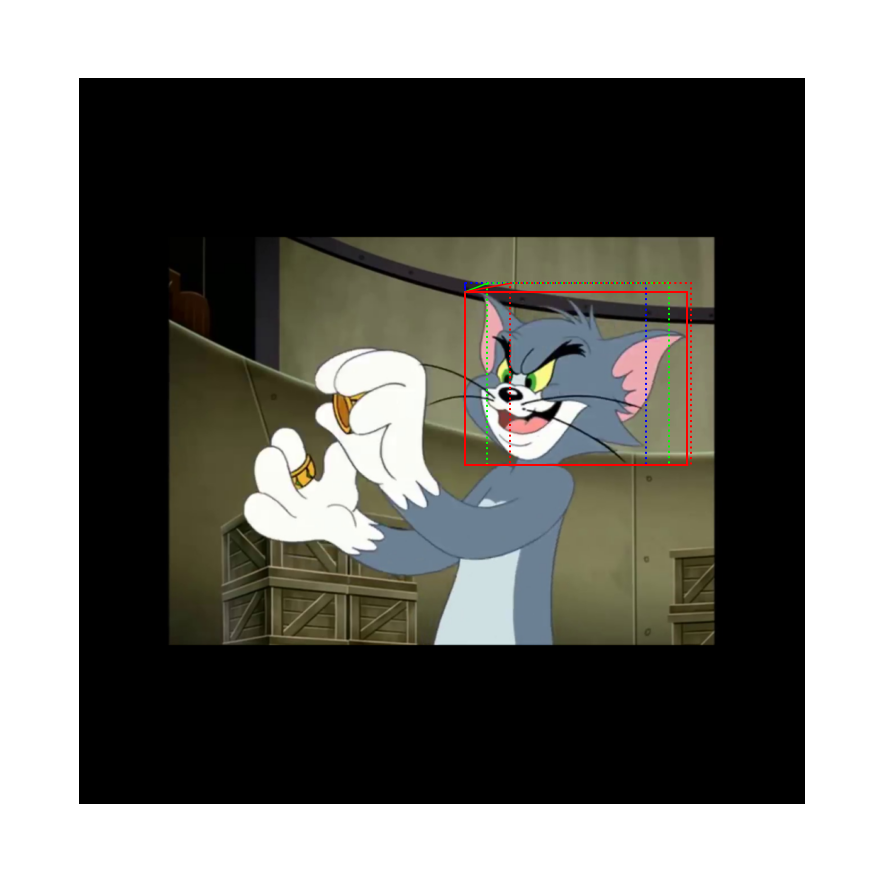

In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image6, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b. RPN Predictions

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min: -362.03867  max: 1322.03870
refined_anchors          shape: (1, 6000, 4)          min: -103630.57031  max: 105059.22656
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (599,)                min:    0.00000  max: 5995.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


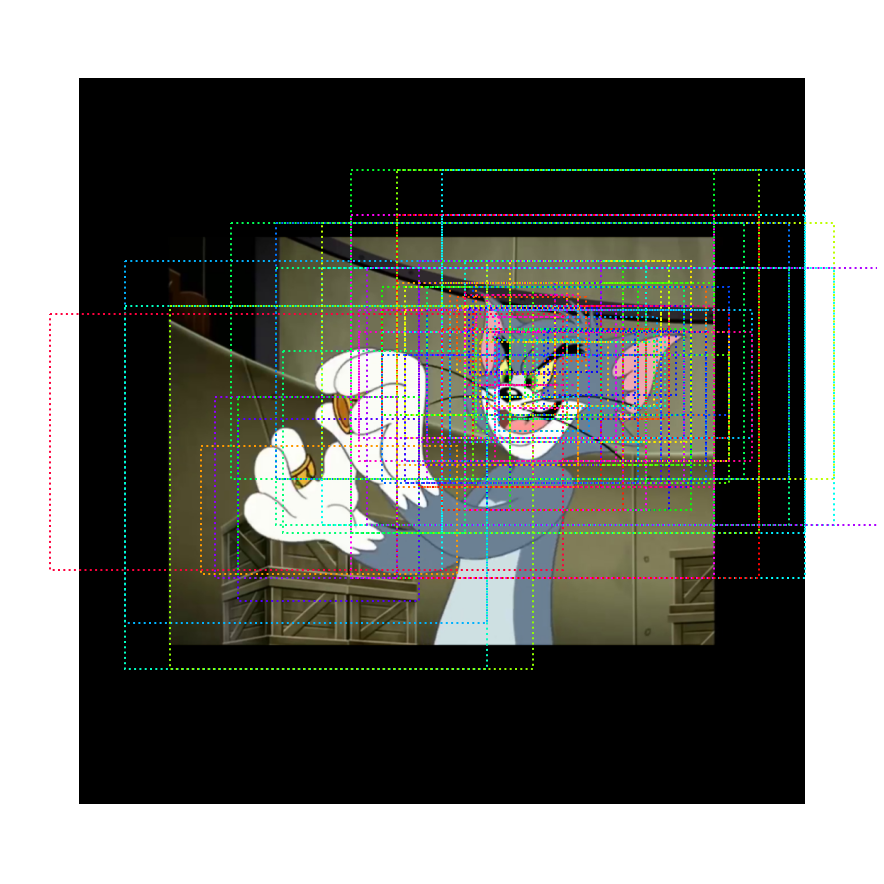

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image6, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

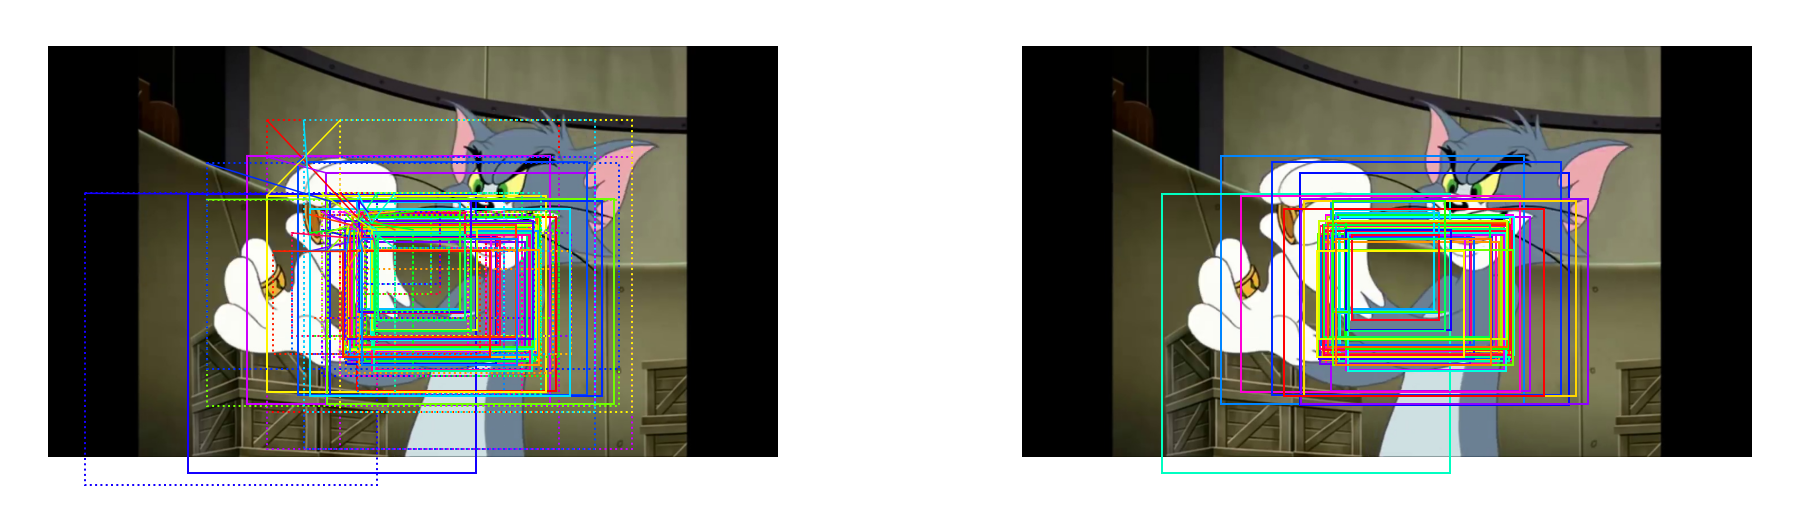

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

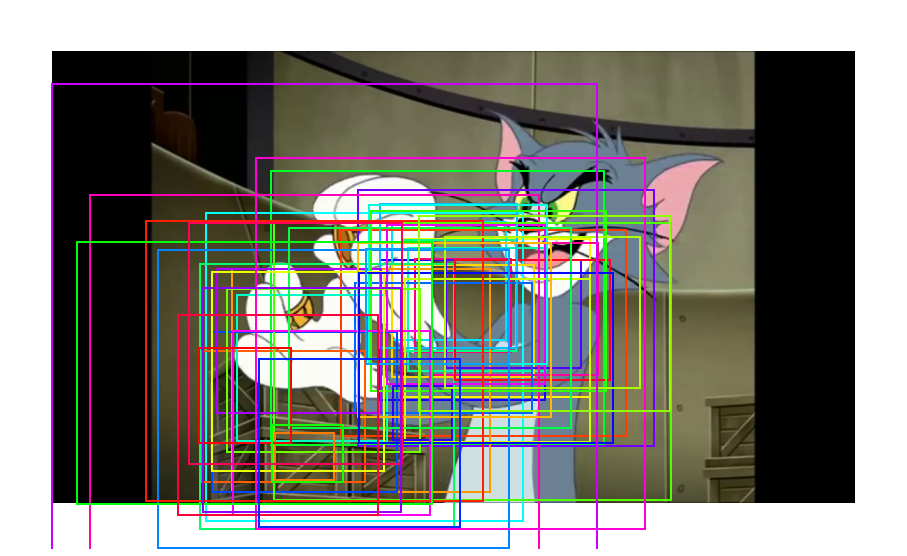

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

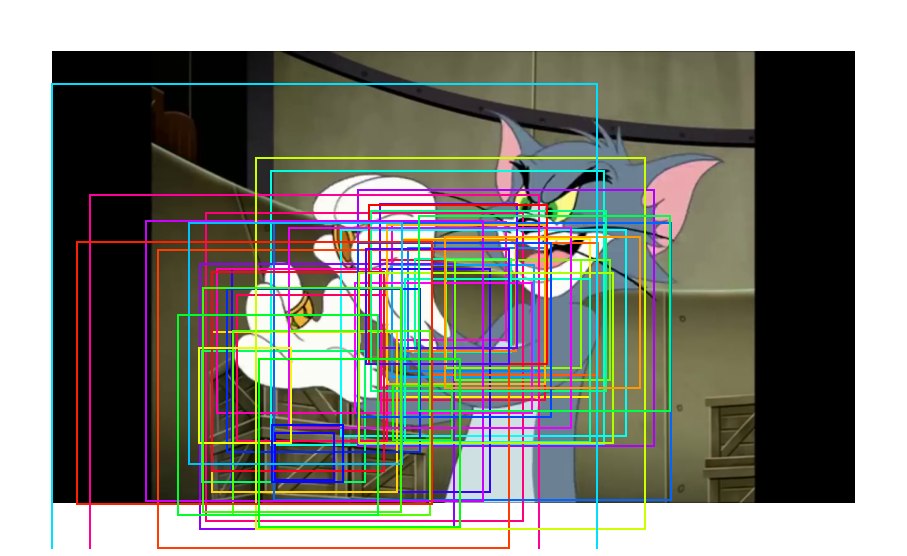

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 3, 4)       min:   -4.03412  max:    5.02930
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000
detections               shape: (1, 100, 6)           min:    0.00000  max:  858.00000


1 detections: ['tom']


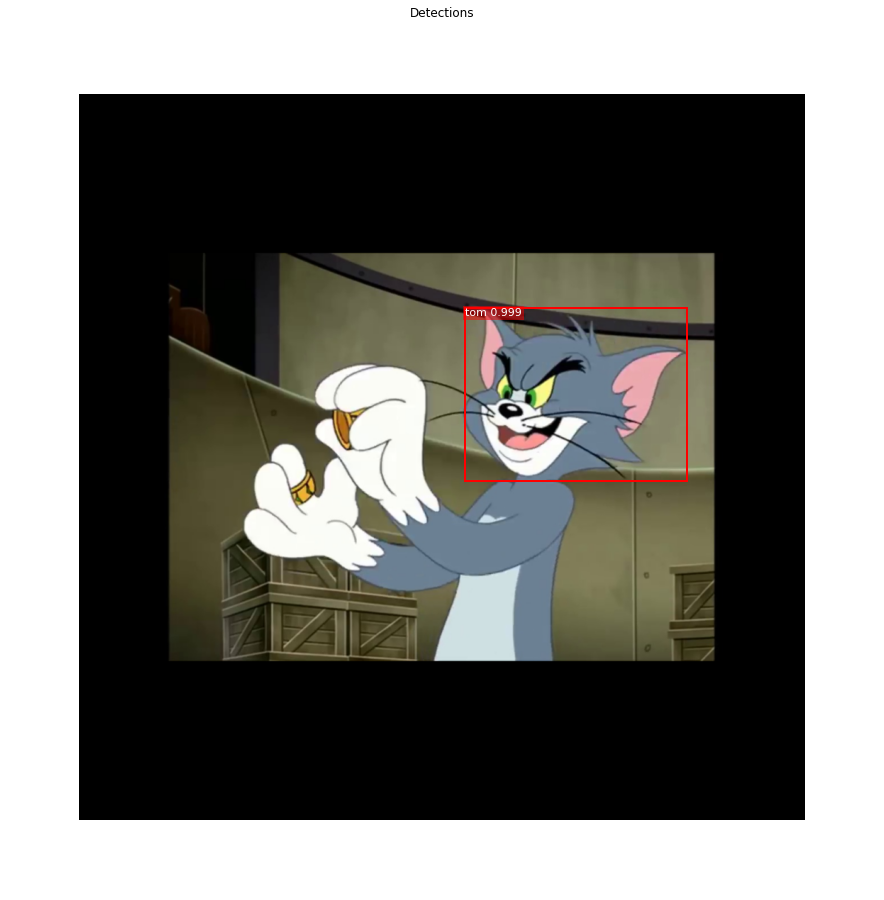

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image6, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions = captions,
     title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

599 Valid proposals out of 1000
17 Positive ROIs
[('BG', 983), ('tom', 17)]


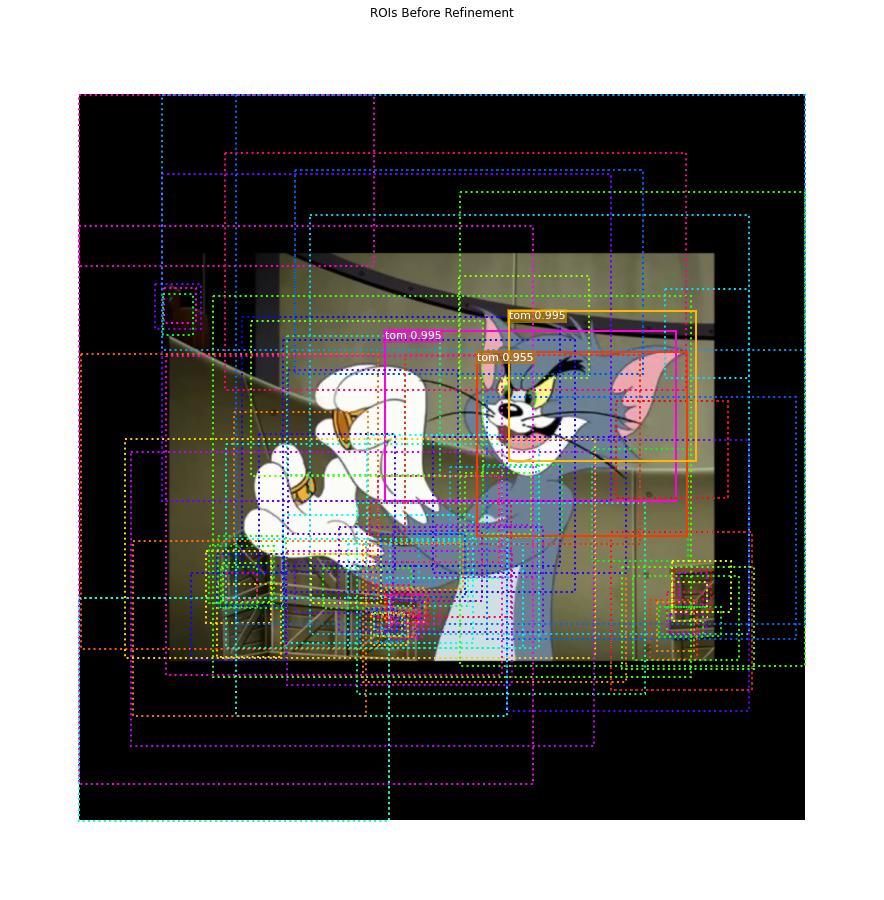

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image6, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.22799  max:    5.02930
refined_proposals        shape: (1000, 4)             min: -235.00000  max: 1268.00000


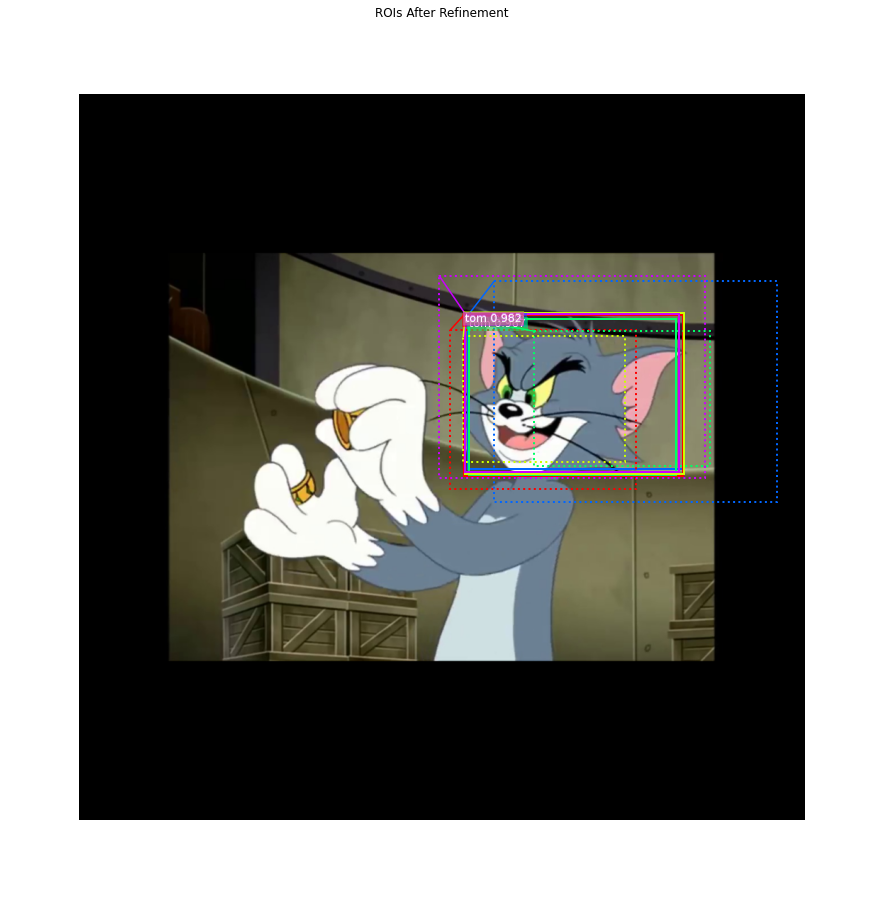

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image6, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 17 detections:
[ 0  4  5  9 10 13 16 17 18 24 28 31 37 38 39 48 65]


In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 14:
[ 0  4  5 10 13 16 17 18 24 28 31 37 39 65]


#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

tom                   : [ 0  4  5 10 13 16 17 18 24 28 31 37 39 65] -> [0]

Kept after per-class NMS: 1
[0]


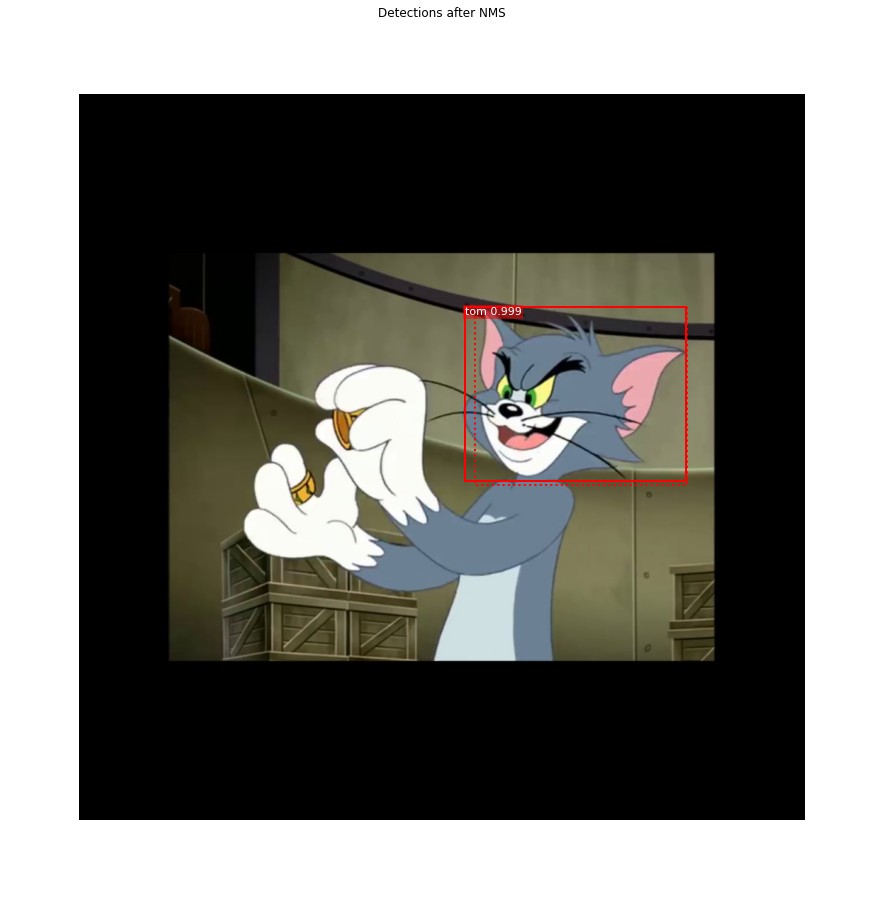

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image6, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

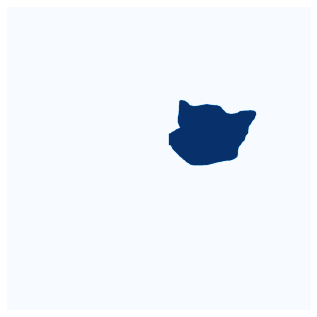

In [ ]:
display_images(np.transpose(r['masks'], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image6], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:  858.00000
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000
1 detections: ['tom']


In [ ]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image6.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 28, 28)           min:    0.00000  max:    1.00000
det_masks                shape: (1, 1024, 1024)       min:    0.00000  max:    1.00000


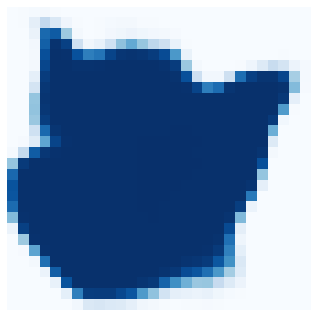

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

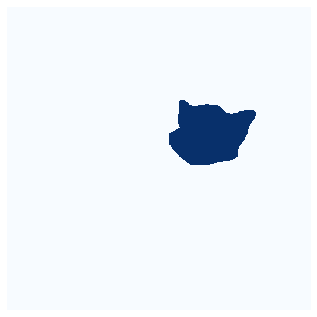

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   30.23311
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80073
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   66.41016
rpn_bbox                 shape: (1, 261888, 4)        min:   -5.19943  max:  106.87341
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


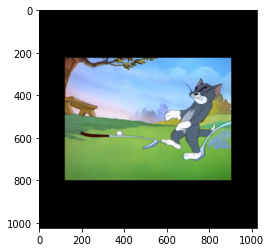

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

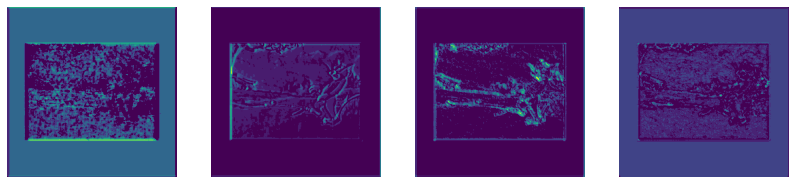

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)